In [ ]:
#default_exp data.annotation

In [ ]:
#export
from collections import UserList
from copy import deepcopy
from dataclasses import replace
from mantisshrimp.imports import *
from mantisshrimp.core import *
from mantisshrimp.data.core import *

# Data annotation
> Functions for getting annotatations in a standard format

## Custom types

In [ ]:
#export
@dataclass
class Mask:
    data: np.ndarray
    def __len__(self): return len(self.data)
    def __getitem__(self, i): return type(self)(self.data[i])
    @property
    def shape(self): return self.data.shape

In [ ]:
#export
@dataclass
class RLE:
    counts: List[int]
    h: int
    w: int

In [ ]:
#export
@dataclass
class Polygon:
    pnts: List[List[int]]
#     h: int
#     w: int
    def to_mask(self, h, w): 
        erle = mask_utils.frPyObjects(list(self.pnts), h, w)
        mask = mask_utils.decode(erle).sum(axis=-1) # Sum is for unconnected polygons
        assert mask.max() == 1, 'Probable overlap in polygons'
        return Mask(mask)

In [ ]:
#export
@dataclass
class BBox:
    pnts: List[int]
    def __post_init__(self):
        if self.pnts:
            xl,yu,xr,yb = self.pnts
            self.x,self.y,self.h,self.w = xl,yu,(yb-yu),(xr-xl)
            self.area = self.h*self.w
    @property
    def xyxy(self): return self.pnts
    @property
    def xywh(self): return [self.x,self.y,self.w,self.h]
    @classmethod
    def from_xywh(cls, x, y, w, h): return cls([x,y,x+w,y+h])
    @classmethod
    def from_xyxy(cls, xl, yu, xr, yb): return cls([xl,yu,xr,yb])

## Annotations

In [ ]:
#export
@dataclass
class ImageInfo:
    # TODO: Can add width and height
    iid: int
    fp: Union[str, Path]
    h: int
    w: int
        
    def __post_init__(self): self.fp = Path(self.fp)

In [ ]:
#export
@dataclass
class Instance:
    oid: int
    bbox: BBox=None
    seg: Polygon=None
    kpts: List=None # TODO
    iscrowd: int=None

In [ ]:
#export
@dataclass
class Annotation:
    iid: int
    oids: List[int]
    bboxes: List[BBox]=None
    segs: List[Polygon]=None
    kpts: List[int]=None # TODO
    iscrowds: List[int]=None
        
    def __post_init__(self):
        # TODO: assert lenghts
        assert len(self.bboxes)==len(self.segs)
    def __getitem__(self, i):
        # TODO: Can be refactored?
        bbox = self.bboxes[i] if notnone(self.bboxes) else None
        seg = self.segs[i] if notnone(self.segs) else None
        kpts = self.kpts[i] if notnone(self.kpts) else None
        iscrowd = self.iscrowds[i] if notnone(self.iscrowds) else None
        return Instance(oid=self.oids[i],bbox=bbox,seg=seg,kpts=None,iscrowd=iscrowd) #kpts None

In [ ]:
#export
@dataclass
class Record:
    iinfo: ImageInfo
    annot: Annotation
        
    @delegates(Annotation.__init__)
    def new(self, **kwargs):
        annot = replace(self.annot, **kwargs)
        return replace(self, annot=annot)

## Parsers

In [ ]:
#export
class ImageParser:
    def __init__(self, data, source): self.data,self.source = data,Path(source)
    def __iter__(self): yield from self.data
    def __len__(self): return len(self.data)
        
    def iid(self, o): raise NotImplementedError
    def file_path(self, o): raise NotImplementedError
    def height(self, o): raise NotImplementedError
    def width(self, o): raise NotImplementedError
        
    def parse(self):
        return [ImageInfo(iid=self.iid(o), fp=self.file_path(o), h=self.height(o), w=self.width(o))
                for o in tqdm(self)]

In [ ]:
#export
class AnnotationParser:
    def __init__(self, data): self.data = data
    def __iter__(self): yield from self.data
    def __len__(self): return len(self.data)
    # Methods to override
    def bbox(self, o): pass
    def iid(self, o): pass
    def seg(self, o): pass
    def iscrowd(self, o): return 0
    
    # TODO: Refactor
    def parse(self):
        res = defaultdict(dict)
        iids = set()
        bboxes = defaultdict(list)
        segs = defaultdict(list)
        oids = defaultdict(list)
        iscrowds = defaultdict(list)
        for o in tqdm(self):
            iid = self.iid(o)
            bbox = self.bbox(o)
            seg = self.seg(o)
            oid = self.oid(o)
            iscrowd = self.iscrowd(o)
            if oid is not None: oids[iid].append(oid)
            if bbox is not None: bboxes[iid].append(bbox)
            if seg is not None: segs[iid].append(seg)
            if iscrowd is not None: iscrowds[iid].append(iscrowd)
            iids.add(iid)
        # TODO: Handle nones
        return [Annotation(i, oids[i], bboxes=bboxes[i], segs=segs[i], iscrowds=iscrowds[i]) for i in iids]

In [ ]:
#export
class DataParser:
    def __init__(self, data, img_source): self.data,self.img_source=data,img_source
    def get_img_parser(self, o, source): raise NotImplementedError
    def get_annot_parser(self, o): raise NotImpletedError
        
    def parse(self):
        imgs = L(self.get_img_parser(self.data, self.img_source).parse())
        annots = L(self.get_annot_parser(self.data).parse())
        # Remove imgs that don't have annotations
        img_iids = set(imgs.attrgot('iid'))
        valid_iids = set(annots.attrgot('iid'))
        if not valid_iids.issubset(img_iids):
            raise ValueError(f'iids {valid_iids-img_iids} present in annotations but not in images')
        valid_imgs = imgs.filter(lambda o: o.iid in valid_iids)
        print(f"Removed {len(imgs)-len(valid_iids)} images that don't have annotations")
        # Sort and get items
        assert len(annots)==len(valid_imgs)
        valid_imgs.sort(attrgetter('iid'))
        annots.sort(attrgetter('iid'))
        return [Record(iinfo,annot) for iinfo,annot in zip(valid_imgs,annots)]

## COCO Parsers

In [ ]:
#export
class COCOImageParser(ImageParser):
    def iid(self, o): return o['id']
    def file_path(self, o): return self.source/o['file_name']
    def height(self, o): return o['height']
    def width(self, o): return o['width']

In [ ]:
#export
class COCOAnnotationParser(AnnotationParser):
    def iid(self, o):  return o['image_id']
    def oid(self, o): return o['category_id']
    def bbox(self, o): return BBox.from_xywh(*o['bbox'])
    def iscrowd(self, o): return o['iscrowd']
    def seg(self, o):
        seg = o['segmentation']
        if o['iscrowd']: return RLE(counts=seg['counts'],h=seg['size'][0],w=seg['size'][1])
        else: return Polygon(seg)

In [ ]:
#export
class COCOParser(DataParser):
    def get_img_parser(self, o, source): return COCOImageParser(o['images'], source)
    def get_annot_parser(self, o): return COCOAnnotationParser(o['annotations'])

In [ ]:
source = Path('samples')
annot_json = json.load((source/'annotations.json').open())

In [ ]:
parser = COCOParser(annot_json, 'samples/images')

In [ ]:
records = parser.parse()


Removed 0 images that don't have annotations


In [ ]:
test_eq(len(records), 5)

In [ ]:
r = records[0]
test_eq((r.iinfo.h, r.iinfo.w), (427, 640))
test_eq(r.iinfo.iid, 128372)
test_eq(r.annot[0].bbox.xywh, [0.0, 73.89, 416.44, 305.13])

In [ ]:
r.annot.segs[0].to_mask(r.iinfo.h, r.iinfo.w).data.shape

(427, 640)

In [ ]:
new = r.new(bboxes=[BBox.from_xyxy(1,2,3,4) for _ in r.annot.bboxes])

In [ ]:
test_ne(new.annot.bboxes, r.annot.bboxes)

## Visualize

In [ ]:
#export
from matplotlib import patches
from matplotlib.collections import PatchCollection

In [ ]:
#export
def show_record(record, im=None, id2cat=None, bbox=False, fontsize=18, ax=None, **kwargs):
    'From github.com/cocodataset/cocoapi/blob/master/PythonAPI/pycocotools/coco.py#L233'
    im = im if notnone(im) else open_img(record.iinfo.fp)
    ax = show_img(im, ax=ax, **kwargs)
    ax.set_autoscale_on(False)
    polygons = []
    color = []
    for ann in record.annot:
        c = (np.random.random((1, 3))*0.6+0.4).tolist()[0]
        # Assert both seg and masks are not present, or unify view
        if ann.seg is not None:
            if isinstance(ann.seg, Polygon):
                for seg in ann.seg.pnts:
                    poly = np.array(seg).reshape((int(len(seg)/2), 2))
                    polygons.append(patches.Polygon(poly))
                    color.append(c)
            elif isinstance(ann.seg, RLE):
                width,height,_ = im.shape
                if isinstance(ann.seg.counts, list):
                    rle = mask_utils.frPyObjects([ann.seg.counts], height, width)
                else:
                    raise NotImplementedError
    #                 rle = [ann['segmentation']]
                m = mask_utils.decode(rle)
                if ann.iscrowd == 1: color_mask = np.array([2.0,166.0,101.0])/255
                if ann.iscrowd == 0: raise NotImplementedError # TODO: I'm not sure how to handle this case
    #                 color_mask = np.random.random((1, 3)).tolist()[0]
            elif isinstance(ann.seg, Mask):
                m = ann.seg.data
                color_mask = np.random.random(3)
            else: raise ValueError(f'Not supported type: {type(ann.seg)}')
            if isinstance(ann.seg, RLE) or isinstance(ann.seg, Mask):
                img = np.ones( (m.shape[0], m.shape[1], 3) )
                for i in range(3):
                    img[:,:,i] = color_mask[i]
                ax.imshow(np.dstack( (img, m*0.5) ))
        if ann.kpts and type(ann['keypoints']) == list:
            raise NotImplementedError
            # turn skeleton into zero-based index
    #                     sks = np.array(self.loadCats(ann['category_id'])[0]['skeleton'])-1
    #                     kp = np.array(ann['keypoints'])
    #                     x = kp[0::3]
    #                     y = kp[1::3]
    #                     v = kp[2::3]
    #                     for sk in sks:
    #                         if np.all(v[sk]>0):
    #                             plt.plot(x[sk],y[sk], linewidth=3, color=c)
    #                     ax.plot(x[v>0], y[v>0],'o',markersize=8, markerfacecolor=c, markeredgecolor='k',markeredgewidth=2)
    #                     ax.plot(x[v>1], y[v>1],'o',markersize=8, markerfacecolor=c, markeredgecolor=c, markeredgewidth=2)

        if bbox:
            [bx, by, bw, bh] = ann.bbox.xywh
            poly = [[bx, by], [bx, by+bh], [bx+bw, by+bh], [bx+bw, by]]
            np_poly = np.array(poly).reshape((4,2))
            polygons.append(patches.Polygon(np_poly))
            color.append(c)
            name = ann.oid if id2cat is None else id2cat[ann.oid]
            ax.text(bx+1, by-2, name, fontsize=fontsize, color='white', va='bottom',
                    bbox=dict(facecolor=c, edgecolor=c, pad=2, alpha=.9))

    p = PatchCollection(polygons, facecolor=color, linewidths=0, alpha=0.4)
    ax.add_collection(p)
    p = PatchCollection(polygons, facecolor='none', edgecolors=color, linewidths=2)
    ax.add_collection(p)

In [ ]:
id2cat = {o['id']:o['name'] for o in annot_json['categories']}

In [ ]:
# Not working on RLE??

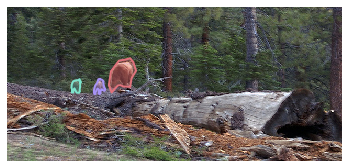

In [ ]:
record = random.choice(records)
show_record(record, id2cat=id2cat, bbox=False)

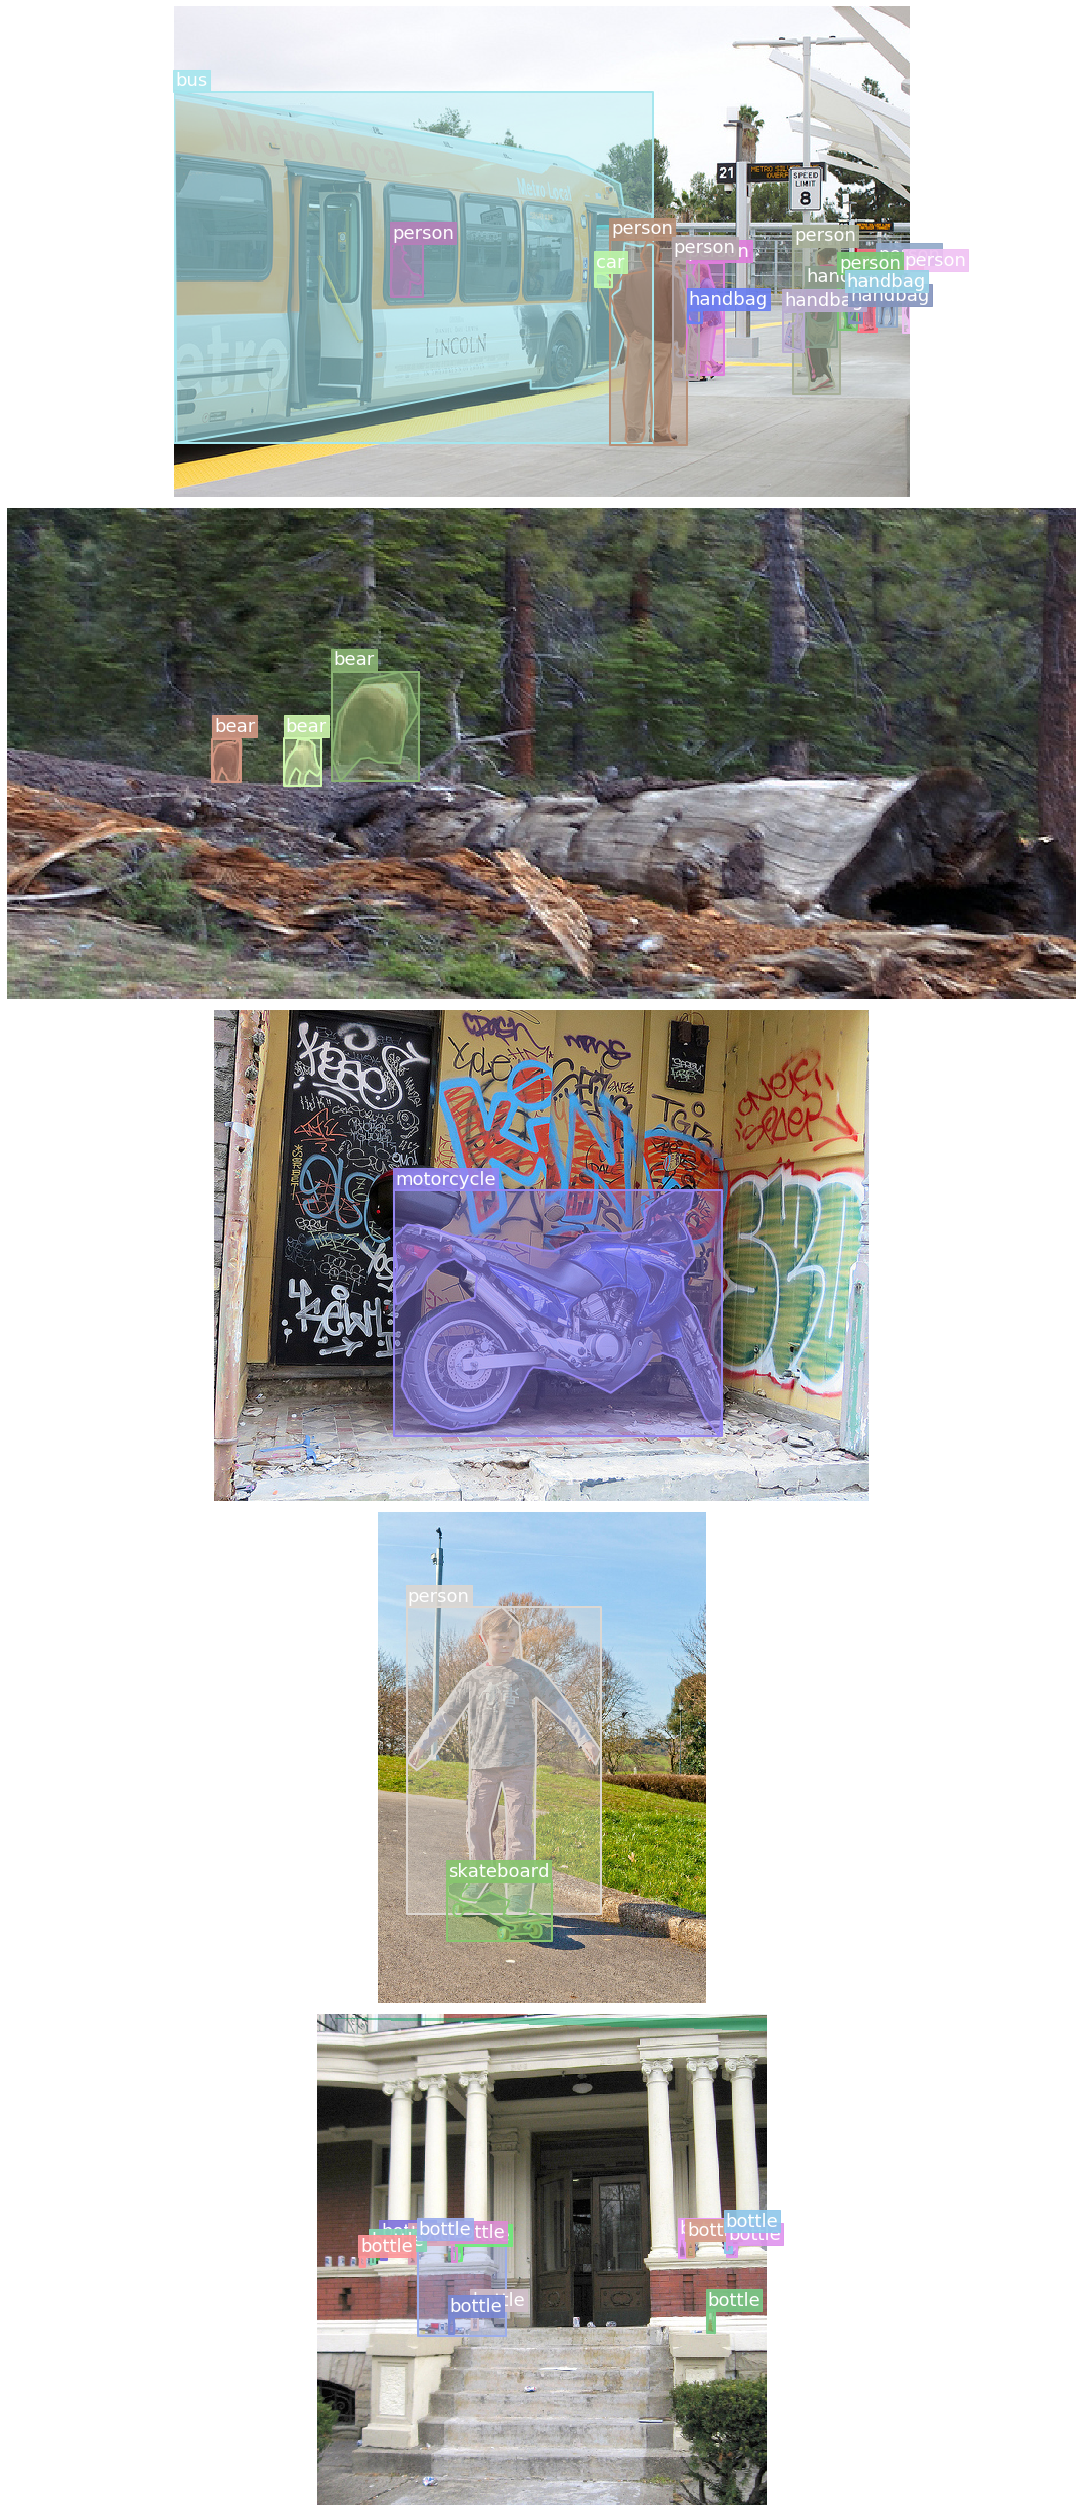

In [ ]:
grid(partial(show_record, id2cat=id2cat, bbox=True), records)

## Export -

In [ ]:
from nbdev.export import notebook2script
notebook2script()

Converted 00_core.ipynb.
Converted 02_data.core.ipynb.
Converted 04_data.annotations.ipynb.
Converted Untitled.ipynb.
Converted Untitled1.ipynb.
Converted index.ipynb.
